# Restaurant Diversity and Demand Analysis of Major Canadian Cities

In [118]:
import numpy as np
import pandas as pd
import requests

from bs4 import BeautifulSoup

import folium

from sklearn.cluster import KMeans
from sklearn import metrics

from scipy.spatial.distance import cdist

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats

import re

!pip install tabulate

In [120]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
TPC_data  = requests.get(url).text
TPC_soup = BeautifulSoup(TPC_data, 'html.parser')

TPC_table = TPC_soup.find('table')
TPC_table_contents = []
for row in TPC_table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        TPC_table_contents.append(cell)

TPC_df = pd.DataFrame(TPC_table_contents)
TPC_df['Borough'] = TPC_df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A', 'East TorontoBusiness reply mail Processing Centre969 Eastern':
                                             'East Toronto Business','EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df_postcode = TPC_df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()

locgeo_df = pd.read_csv('https://cocl.us/Geospatial_data', index_col='Postal Code')

toronto_data = df_postcode.join(locgeo_df, on='PostalCode')

print(toronto_data.to_markdown()) 

  PostalCode      Borough                            Neighborhood   Latitude  \
0        M1B  Scarborough                          Malvern, Rouge  43.806686   
1        M1C  Scarborough  Rouge Hill, Port Union, Highland Creek  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476  


In [80]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_H'
MPC_data  = requests.get(url).text
MPC_soup = BeautifulSoup(MPC_data, 'html.parser')

MPC_table = MPC_soup.find('table')
MPC_table_contents = []
for row in MPC_table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned' or row.p.text[:2]=='H0' or row.p.text[:2]=='H7':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Neighborhood'] = re.sub(r"(\w)([A-Z])", r"\1 \2",(row.span.text))
        MPC_table_contents.append(cell)

MPC_df = pd.DataFrame(MPC_table_contents)

Mdf_postcode = MPC_df.groupby(['PostalCode'])['Neighborhood'].apply(', '.join).reset_index()

Mlocgeo_df = pd.read_csv('https://raw.githubusercontent.com/ReidZaffino/Coursera_Capstone/main/Montreal_Geospatial_Coordinates.csv', index_col='Postal Code')

montreal_data = Mdf_postcode.join(Mlocgeo_df, on='PostalCode')

In [81]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V'
VPC_data  = requests.get(url).text
VPC_soup = BeautifulSoup(VPC_data, 'html.parser')

VPC_table = VPC_soup.find('table')
VPC_table_contents = []
for row in VPC_table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned' or not("Vancouver(" in row.span.text):
        pass
    else:
         cell['PostalCode'] = row.b.text[:3]
         cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
         VPC_table_contents.append(cell)

VPC_df = pd.DataFrame(VPC_table_contents)

Vdf_postcode = VPC_df.groupby(['PostalCode'])['Neighborhood'].apply(', '.join).reset_index()

Vlocgeo_df = pd.read_csv('https://raw.githubusercontent.com/ReidZaffino/Coursera_Capstone/main/Vancouver_Geospatial_Coordinates.csv', index_col='Postal Code')

vancouver_data = Vdf_postcode.join(Vlocgeo_df, on='PostalCode')

In [5]:
CLIENT_ID = 'D1OA3GICFE0DQBPVFGT1LXPMECFEYX32MIAUWEDCIEDKDSAO' # your Foursquare ID
CLIENT_SECRET = 'FYYWHEPCUN43OZ344ZDXL5IHHZPHWL4J3P2V3JTQ2SLU1BTQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50 # A default Foursquare API limit value

In [6]:
def getNearbyRestaurants(names, latitudes, longitudes, radius):
    
    restaurants_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby restaurant
        restaurants_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results]) #

    nearby_restaurants = pd.DataFrame([item for restaurant_list in restaurants_list for item in restaurant_list])
    nearby_restaurants.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_restaurants)

In [7]:
toronto_restaurants = getNearbyRestaurants(toronto_data['Neighborhood'], toronto_data['Latitude'], toronto_data['Longitude'], 1400)
montreal_restaurants = getNearbyRestaurants(montreal_data['Neighborhood'], montreal_data['Latitude'], montreal_data['Longitude'], 1000)
vancouver_restaurants = getNearbyRestaurants(vancouver_data['Neighborhood'], vancouver_data['Latitude'], vancouver_data['Longitude'], 1000)

In [8]:
t_r = toronto_restaurants.drop_duplicates(subset=['Venue', 'Venue Latitude', 'Venue Longitude'])
m_r = montreal_restaurants.drop_duplicates(subset=['Venue', 'Venue Latitude', 'Venue Longitude'])
v_r = vancouver_restaurants.drop_duplicates(subset=['Venue', 'Venue Latitude', 'Venue Longitude'])

<AxesSubplot:title={'center':'Toronto Top 20 Most Common Restaurant Types'}>

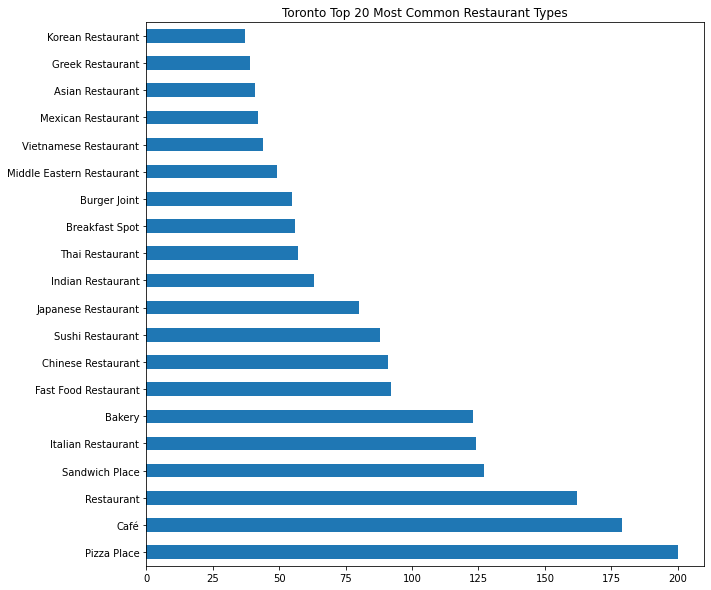

In [9]:
t_r['Venue Category'].value_counts().head(20).plot(kind='barh', figsize=(10, 10), title = "Toronto Top 20 Most Common Restaurant Types")

<AxesSubplot:title={'center':'Montreal Top 20 Most Common Restaurant Types'}>

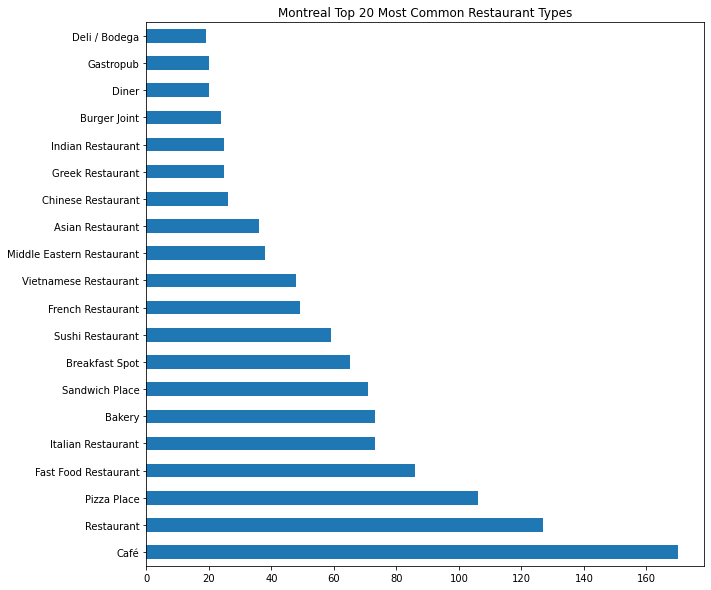

In [10]:
m_r['Venue Category'].value_counts().head(20).plot(kind='barh', figsize=(10, 10), title = "Montreal Top 20 Most Common Restaurant Types")

<AxesSubplot:title={'center':'Vancouver Top 20 Most Common Restaurant Types'}>

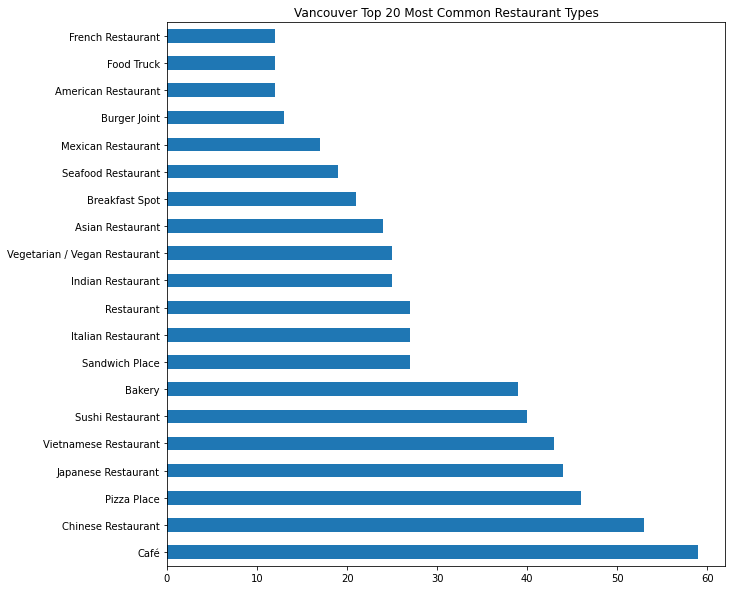

In [11]:
v_r['Venue Category'].value_counts().head(20).plot(kind='barh', figsize=(10, 10), title = "Vancouver Top 20 Most Common Restaurant Types")

In [12]:
# one hot encoding
toronto_onehot = pd.get_dummies(t_r[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = t_r['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [13]:
# one hot encoding
montreal_onehot = pd.get_dummies(m_r[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
montreal_onehot['Neighborhood'] = m_r['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [montreal_onehot.columns[-1]] + list(montreal_onehot.columns[:-1])
montreal_onehot = montreal_onehot[fixed_columns]

montreal_grouped = montreal_onehot.groupby('Neighborhood').mean().reset_index()

In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [15]:
t_num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(t_num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
t_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
t_neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    t_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], t_num_top_venues)

In [16]:
m_num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(m_num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
m_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
m_neighborhoods_venues_sorted['Neighborhood'] = montreal_grouped['Neighborhood']

for ind in np.arange(montreal_grouped.shape[0]):
    m_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(montreal_grouped.iloc[ind, :], m_num_top_venues)

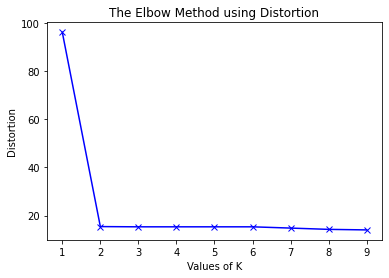

In [17]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
t_distortions = []
K = range(1, 10)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
    kmeanModel.fit(toronto_grouped_clustering)
 
    t_distortions.append(sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_,'canberra'), axis=1)) / toronto_grouped_clustering.shape[0])
 
plt.plot(K, t_distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

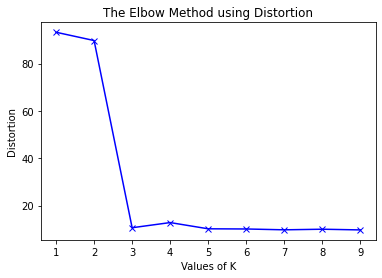

In [18]:
montreal_grouped_clustering = montreal_grouped.drop('Neighborhood', 1)
m_distortions = []
K = range(1, 10)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, random_state=16).fit(montreal_grouped_clustering)
    kmeanModel.fit(montreal_grouped_clustering)
 
    m_distortions.append(sum(np.min(cdist(montreal_grouped_clustering, kmeanModel.cluster_centers_,'canberra'), axis=1)) / montreal_grouped_clustering.shape[0])
 
plt.plot(K, m_distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [20]:
# set number of clusters
t_kclusters = 2

# run k-means clustering
t_kmeans = KMeans(n_clusters=t_kclusters, random_state=2).fit(toronto_grouped_clustering)

#### add clustering labels
#t_neighborhoods_venues_sorted = t_neighborhoods_venues_sorted.drop('Cluster Labels', axis = 1)

t_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', t_kmeans.labels_)

toronto_merged = toronto_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(t_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# removing neighborhoods that did not have any foursquare query responses
toronto_merged.dropna(inplace = True)

In [21]:
# set number of clusters
m_kclusters = 3

# run k-means clustering
m_kmeans = KMeans(n_clusters=m_kclusters, random_state=0).fit(montreal_grouped_clustering)

#### add clustering labels
#m_neighborhoods_venues_sorted = m_neighborhoods_venues_sorted.drop('Cluster Labels', axis = 1)

m_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', m_kmeans.labels_)

montreal_merged = montreal_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
montreal_merged = montreal_merged.join(m_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# removing neiborhoods that did not have any foursquare query responses
montreal_merged.dropna(inplace = True)

In [22]:
# create map
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# set color scheme for the clusters
x = np.arange(t_kclusters)
ys = [i + x + (i*x)**2 for i in range(t_kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster) - 1],
        fill=True,
        fill_color=rainbow[int(cluster) - 1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [23]:
# create map
map_clusters = folium.Map(location=[45.5017, -73.5673], zoom_start=10)

# set color scheme for the clusters
x = np.arange(m_kclusters)
ys = [i + x + (i*x)**2 for i in range(m_kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(montreal_merged['Latitude'], montreal_merged['Longitude'], montreal_merged['Neighborhood'], montreal_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster) - 1],
        fill=True,
        fill_color=rainbow[int(cluster) - 1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [96]:
tdf = pd.read_csv('https://raw.githubusercontent.com/ReidZaffino/Coursera_Capstone/main/Toronto-Restaurants.csv', encoding='cp1252')
mdf = pd.read_csv('https://raw.githubusercontent.com/ReidZaffino/Coursera_Capstone/main/Montreal-Restaurants.csv', encoding='cp1252')
vdf = pd.read_csv('https://raw.githubusercontent.com/ReidZaffino/Coursera_Capstone/main/Vancouver-Restaurants.csv', encoding='cp1252')

(0.5086992941672821, 6.525930319491094e-08)

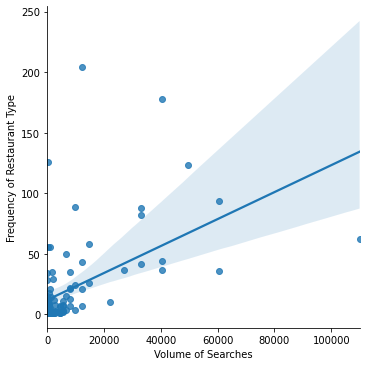

In [101]:
tpruned = tdf.drop(labels=[12, 37, 79, 6], axis=0)
sns.lmplot(x='Volume of Searches',y='Frequency of Restaurant Type', data=tpruned);
stats.pearsonr(tpruned['Volume of Searches'], tpruned['Frequency of Restaurant Type'])

(0.4113665804663875, 3.4530843895641514e-05)

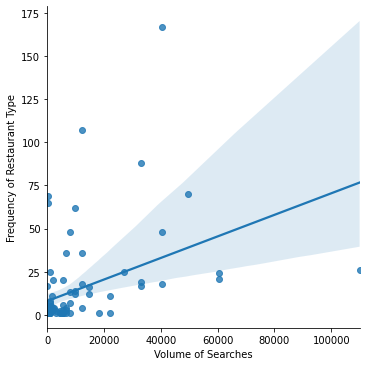

In [102]:
mpruned = mdf.drop(labels=[74, 36, 5], axis=0)
sns.lmplot(x='Volume of Searches',y='Frequency of Restaurant Type', data=mpruned);
stats.pearsonr(mpruned['Volume of Searches'], mpruned['Frequency of Restaurant Type'])

(0.55691032512345, 1.1895799499497202e-07)

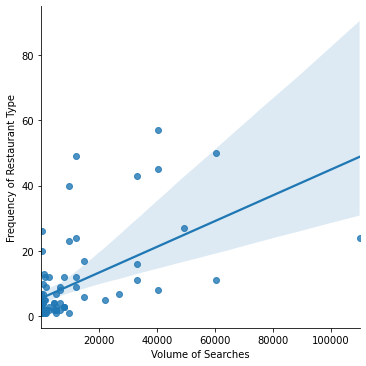

In [103]:
vpruned = vdf.drop(labels=[59, 28, 4], axis=0)
sns.lmplot(x='Volume of Searches',y='Frequency of Restaurant Type', data=vpruned);
stats.pearsonr(vpruned['Volume of Searches'], vpruned['Frequency of Restaurant Type'])

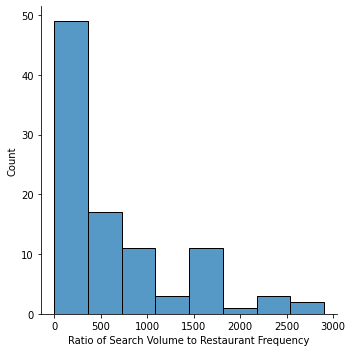

In [105]:
tRatio = tpruned['Volume of Searches']/tpruned['Frequency of Restaurant Type']
#tpruned = tpruned.drop('Ratio of Search Volume to Restaurant Frequency', axis = 1)
tpruned.insert(3, 'Ratio of Search Volume to Restaurant Frequency', tRatio)
sns.displot(data = tpruned.drop(labels=[56, 45, 71], axis=0), x ='Ratio of Search Volume to Restaurant Frequency', bins = 8)

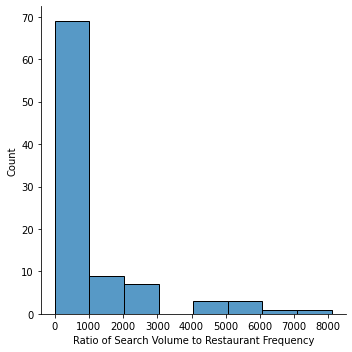

In [106]:
mRatio = mpruned['Volume of Searches']/mpruned['Frequency of Restaurant Type']
#mpruned = mpruned.drop('Ratio of Search Volume to Restaurant Frequency', axis = 1)
mpruned.insert(3, 'Ratio of Search Volume to Restaurant Frequency', mRatio)
sns.displot(data = mpruned.drop(labels=[9, 44], axis=0), x ='Ratio of Search Volume to Restaurant Frequency', bins = 8)

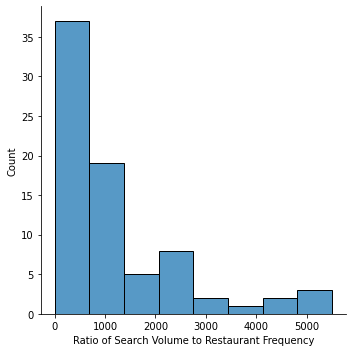

In [107]:
vRatio = vpruned['Volume of Searches']/vpruned['Frequency of Restaurant Type']
#vpruned = vpruned.drop('Ratio of Search Volume to Restaurant Frequency', axis = 1)
vpruned.insert(3, 'Ratio of Search Volume to Restaurant Frequency', vRatio)
sns.displot(data = vpruned.drop(labels=[7], axis=0), x ='Ratio of Search Volume to Restaurant Frequency', bins = 8)

In [108]:
#Buffet, Bakery, Restaurant, Food
ttop_35 = tpruned.sort_values('Volume of Searches', ascending = False).head(35)
mtop_35 = mpruned.drop(labels=[9]).sort_values('Volume of Searches', ascending = False).head(35)
vtop_35 = vpruned.sort_values('Volume of Searches', ascending = False).head(35)

In [109]:
ttop_35.sort_values('Ratio of Search Volume to Restaurant Frequency', ascending = False).head(10)

,Restaurant Type,Volume of Searches,Frequency of Restaurant Type,Ratio of Search Volume to Restaurant Frequency
62,Malay Restaurant,5400,2,2700.000000
9,Bistro,9900,4,2475.000000
89,Steakhouse,22200,10,2220.000000
22,Creperie,5400,3,1800.000000
0,Afghan Restaurant,5400,3,1800.000000
54,Indian Restaurant,110000,62,1774.193548
40,Food Truck,12100,7,1728.571429
26,Diner,60500,36,1680.555556
72,Persian Restaurant,6600,4,1650.000000
99,Turkish Restaurant,8100,7,1157.142857


In [110]:
mtop_35.sort_values('Ratio of Search Volume to Restaurant Frequency', ascending = False).head(10)

,Restaurant Type,Volume of Searches,Frequency of Restaurant Type,Ratio of Search Volume to Restaurant Frequency
44,Halal Restaurant,18100,1,18100.000000
94,Turkish Restaurant,8100,1,8100.000000
54,Lebanese Restaurant,6600,1,6600.000000
14,Cafeteria,5400,1,5400.000000
0,Afghan Restaurant,5400,1,5400.000000
56,Malay Restaurant,5400,1,5400.000000
47,Indian Restaurant,110000,26,4230.769231
38,Food Truck,12100,4,3025.000000
25,Diner,60500,21,2880.952381
19,Chinese Restaurant,60500,24,2520.833333


In [111]:
vtop_35.sort_values('Ratio of Search Volume to Restaurant Frequency', ascending = False).head(10)

,Restaurant Type,Volume of Searches,Frequency of Restaurant Type,Ratio of Search Volume to Restaurant Frequency
7,Bistro,9900,1,9900.000000
21,Diner,60500,11,5500.000000
12,Cafeteria,5400,1,5400.000000
44,Korean Restaurant,40500,8,5062.500000
39,Indian Restaurant,110000,24,4583.333333
70,Steakhouse,22200,5,4440.000000
35,Greek Restaurant,27100,7,3871.428571
67,South Indian Restaurant,6600,2,3300.000000
26,Fast Food Restaurant,33100,11,3009.090909
57,Portuguese Restaurant,5400,2,2700.000000


In [112]:
ttop_35.sort_values('Ratio of Search Volume to Restaurant Frequency', ascending = True).head(10)

,Restaurant Type,Volume of Searches,Frequency of Restaurant Type,Ratio of Search Volume to Restaurant Frequency
74,Pizza Place,12100,204,59.313725
90,Sushi Restaurant,9900,89,111.235955
65,Middle Eastern Restaurant,6600,50,132.000000
15,Café,40500,178,227.528090
19,Caribbean Restaurant,8100,35,231.428571
96,Thai Restaurant,14800,58,255.172414
4,Asian Restaurant,12100,43,281.395349
41,French Restaurant,8100,22,368.181818
34,Fast Food Restaurant,33100,88,376.136364
63,Mediterranean Restaurant,8100,21,385.714286


In [113]:
mtop_35.sort_values('Ratio of Search Volume to Restaurant Frequency', ascending = True).head(10)

,Restaurant Type,Volume of Searches,Frequency of Restaurant Type,Ratio of Search Volume to Restaurant Frequency
69,Pizza Place,12100,107,113.084112
86,Sushi Restaurant,9900,62,159.677419
39,French Restaurant,8100,48,168.750000
59,Middle Eastern Restaurant,6600,36,183.333333
13,Café,40500,167,242.514970
71,Portuguese Restaurant,5400,20,270.000000
3,Asian Restaurant,12100,36,336.111111
34,Fast Food Restaurant,33100,88,376.136364
57,Mediterranean Restaurant,8100,13,623.076923
23,Deli / Bodega,12100,18,672.222222


In [114]:
vtop_35.sort_values('Ratio of Search Volume to Restaurant Frequency', ascending = True).head(10)

,Restaurant Type,Volume of Searches,Frequency of Restaurant Type,Ratio of Search Volume to Restaurant Frequency
55,Pizza Place,12100,49,246.938776
71,Sushi Restaurant,9900,40,247.500000
79,Vegetarian / Vegan Restaurant,9900,23,430.434783
2,Asian Restaurant,12100,24,504.166667
31,French Restaurant,8100,12,675.000000
11,Cafe,40500,57,710.526316
51,Middle Eastern Restaurant,6600,9,733.333333
43,Japanese Restaurant,33100,43,769.767442
48,Malay Restaurant,5400,7,771.428571
58,Ramen Restaurant,6600,8,825.000000
